In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [505]:
label_path = './data/data_by_table/pre_24h_data_v3.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'
raw_data_path = './data/data_by_table/pre_24_merged_29_cols.csv'

data_df = pd.read_csv(label_path)
flag_data_df = pd.read_csv(flag_data_path)
label_df = pd.read_csv(label_path)
data_df['BMI'] = data_df['weight_kg'] / ((data_df['height_cm'] / 100) ** 2)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])
data_df = data_df.drop(columns=['height_cm', 'weight_kg'])
data_df['RSBI'] =  data_df['tidal_volume_observed'] / data_df['resp_rate']
data_df['minute_ventilation'] = data_df['tidal_volume_observed'] * data_df['resp_rate']
print(data_df.columns)
print(data_df['charttime'])

Index(['Unnamed: 0', 'charttime', 'stay_id', 'O2_flow_x', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',
       'first_careunit', 'tobacco', 'label', 'Rev_h', 'dod_h', 'BMI', 'RSBI',
       'minute_ventilation'],
      dtype='object')
0        2144-01-11 20:00:00
1        2144-01-11 21:00:00
2        2144-01-11 22:00:00
3        2144-01-11 23:00:00
4        2144-01-12 00:00:00
                ...         
68155    2124-08-21 05:00:00
68156    2124-08-21 06:00:00
68157    2124-08-21 07:00:00
68158    2124-08-21 08:00:00
68159    2124-08-21 09:00:00
Name: charttime, Length: 68160, dtype: object


In [429]:
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 

In [430]:
def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = -72
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = 48 - id_df['Rev_h'].iloc[0]
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = (96 - id_df['dod_h'].iloc[0]*2)
                else:
                    label = 96 
    return label

In [273]:
def lstm_data(flag_data_df, data_df):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            id_df = id_df.drop(columns='dod_h')
            total_x.append(id_df.values)
            total_y.append(label)

    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y

In [491]:
def get_diff_value(df,colname,start, end):
    start = 23 - start
    end = 23 - end
    df = df.reset_index()
    return (df[colname][end]+df[colname][end-1]+df[colname][end-2]) - (df[colname][start]+df[colname][start+1]+df[colname][start+2])

def get_max_min(df,colname):
    max_value = df[colname].max()
    min_value = df[colname].min()
    result = max_value - min_value
    return result

def get_min(df, col):
    if df.empty or col not in df.columns:
        return float('nan')
    else:
        return df[col].min()

def get_max(df, col):
    if df.empty or col not in df.columns:
        return float('nan')
    else:
        return df[col].max()

def get_mean(df, col):
    return df[col].mean()

In [366]:
'''
'charttime', 'stay_id', 'O2_flow_x', 'heart_rate', 'sbp',
'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',
'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',
'first_careunit', 'tobacco', 'label', 'Rev_h', 'dod_h', 'BMI'],
'''

"\n'charttime', 'stay_id', 'O2_flow_x', 'heart_rate', 'sbp',\n'dbp', 'mbp', 'resp_rate', 'spo2', 'O2_flow_y', 'peep', 'fio2',\n'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',\n'GCS', 'age_now', 'gender', 'insurance', 'race', 'admission_type',\n'first_careunit', 'tobacco', 'label', 'Rev_h', 'dod_h', 'BMI'],\n"

In [485]:
def generate_more_feature(df, columns, feature_list):
    for col in columns:
        feature_list = np.append(feature_list, get_diff_value(df,col,10,0))
        feature_list = np.append(feature_list, get_diff_value(df,col,20,0))
        feature_list = np.append(feature_list, df[col].std())
        feature_list = np.append(feature_list,  get_max_min(df, col))
        feature_list = np.append(feature_list,  get_min(df, col))
        feature_list = np.append(feature_list,  get_max(df, col))
        feature_list = np.append(feature_list,  get_mean(df, col))
    return feature_list

In [486]:
aug_columns = ['spo2','peep','heart_rate','respiratory_rate_set','plateau_pressure','tidal_volume_observed','fio2','O2_flow_x','sbp','dbp','mbp','resp_rate','RSBI','minute_ventilation']

def NN_data(flag_data_df, data_df,label_df,  hour = 23):
    total_x = []
    total_y = []
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        id_df_label = label_df[label_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df):
            label = get_label(id_df_label)
            id_df = id_df.drop(columns='stay_id')
            id_df = id_df.drop(columns='label')
            id_df = id_df.drop(columns='charttime')
            id_df = id_df.drop(columns='Rev_h')
            id_df = id_df.drop(columns='dod_h')

            
            zero_hr_values = id_df.iloc[hour, :].values
            zero_hr_values = generate_more_feature(id_df, aug_columns ,zero_hr_values)


            total_x.append(zero_hr_values)
            total_y.append(label)
    total_x = np.array(total_x)
    total_y = np.array(total_y).reshape(-1, 1)
    return total_x, total_y
        

In [418]:
lstm_x, lstm_y = lstm_data(flag_data_df, data_df)

In [249]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def train_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch):

    # Define model and train
    def build_lstm_model(timesteps, num_features):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=(timesteps, num_features)),
            tf.keras.layers.Dense(1) 
        ])
        model.build(input_shape=(None, timesteps, num_features))
        return model

    model = build_lstm_model(timesteps=X_train.shape[1], num_features=X_train.shape[2])

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))
    return model



In [501]:
def train_NN_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch, verbose=1):

    # Define model and train
    def build_nn_model(input_shape):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='mean_squared_error')
        return model

    # Build and compile the model
    model = build_nn_model(input_shape=(X_train.shape[1],))

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test), verbose=verbose)
    return model

In [492]:
total_x, total_y = NN_data(flag_data_df, data_df, label_df, 23)
print(total_x.shape)
print(total_y.shape)

(2003, 123)
(2003, 1)


In [502]:
# total_x = lstm_x
# total_y = lstm_y
total_x = total_x.astype(np.float32)
total_y = total_y.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
# Handle NaN values by replacing them with zeros (you can choose a different strategy)
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)

X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2, random_state=4277)
print(X_train.shape)
print(y_train.shape)
model = train_NN_module(X_train, y_train, X_test, y_test, epoch= 50, learning_rate=0.001, batch=32)

(1602, 123)
(1602, 1)
Epoch 1/50
51/51 [==============================] - 1s 9ms/step - loss: 4401.5273 - val_loss: 3984.8567
Epoch 2/50
51/51 [==============================] - 0s 6ms/step - loss: 4098.0347 - val_loss: 3825.9060
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 3806.5608 - val_loss: 3516.1355
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 3453.1475 - val_loss: 3384.9963
Epoch 5/50
51/51 [==============================] - 0s 7ms/step - loss: 3157.7651 - val_loss: 3163.5830
Epoch 6/50
51/51 [==============================] - 0s 5ms/step - loss: 3075.4646 - val_loss: 3040.4065
Epoch 7/50
51/51 [==============================] - 0s 5ms/step - loss: 2987.7891 - val_loss: 3138.0601
Epoch 8/50
51/51 [==============================] - 0s 5ms/step - loss: 2958.0205 - val_loss: 3142.8953
Epoch 9/50
51/51 [==============================] - 0s 5ms/step - loss: 2934.5693 - val_loss: 2990.8923
Epoch 10/50
51/51 [=======================

In [503]:
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0, 1, 0)
y_label = np.where(y_test > 0, 1, 0)

13/13 [==============================] - 0s 3ms/step


AUC-ROC: 0.7367009511170095


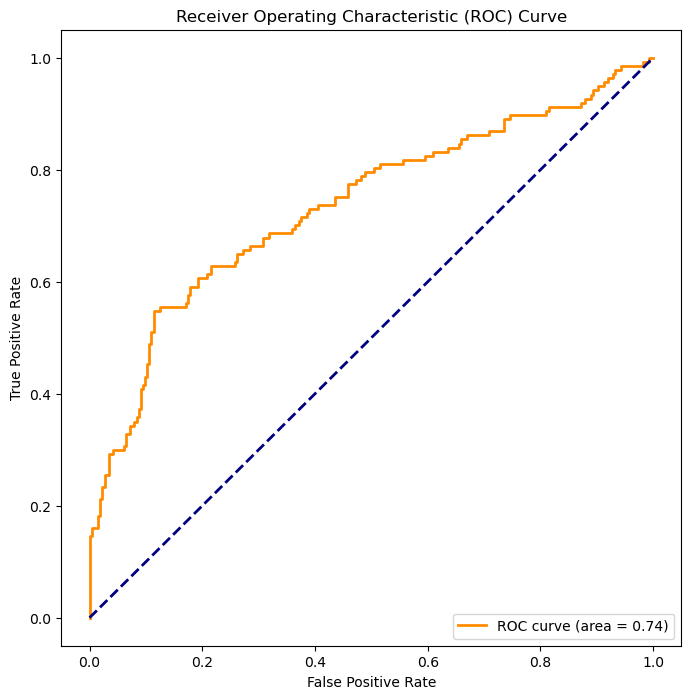

In [504]:
fpr, tpr, _ = roc_curve(y_label, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# experiment

In [363]:
hour_before_weaninig = []
auroc = []
models = []

for i in range (24):
    total_x, total_y = NN_data(flag_data_df, data_df, i)
    total_x = total_x.astype(np.float32)
    total_y = total_y.astype(np.float32)
    total_x[np.isinf(total_x)] = np.nan
    total_x[np.abs(total_x) > 1e6] = np.nan
    total_x[np.isnan(total_x)] = 0.0
    scaler = MinMaxScaler()
    total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)
    X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2, random_state=42)
    model = train_NN_module(X_train, y_train, X_test, y_test, epoch= 100, learning_rate=0.001, batch=32, verbose=0)
    y_pred_proba = model.predict(X_test)
    y_pred = np.where(y_pred_proba > 0, 1, 0)
    y_label = np.where(y_test > 0, 1, 0)
    fpr, tpr, _ = roc_curve(y_label, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    hour_before_weaninig.append(i)
    auroc.append(roc_auc)
    models.append(model)
    print(i, roc_auc)

13/13 [==============================] - 0s 3ms/step
0 0.7139299397920089
13/13 [==============================] - 0s 3ms/step
1 0.7057744937055281
13/13 [==============================] - 0s 3ms/step
2 0.7212917350848387
13/13 [==============================] - 0s 2ms/step
3 0.7105090311986864
13/13 [==============================] - 0s 2ms/step
4 0.7060755336617406
13/13 [==============================] - 0s 2ms/step
5 0.7070607553366175
13/13 [==============================] - 0s 2ms/step
6 0.6904761904761905
13/13 [==============================] - 0s 2ms/step
7 0.6740284619594965
13/13 [==============================] - 0s 2ms/step
8 0.6889162561576355
13/13 [==============================] - 0s 2ms/step
9 0.687055281882868
13/13 [==============================] - 0s 2ms/step
10 0.6985495347564313
13/13 [==============================] - 0s 3ms/step
11 0.7072523262178434
13/13 [==============================] - 0s 3ms/step
12 0.7138204707170225
13/13 [=============================

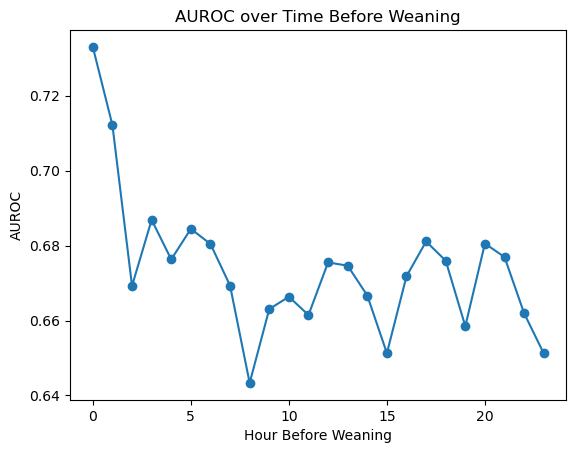

In [362]:
import matplotlib.pyplot as plt
hour_before_weaninig = hour_before_weaninig[::-1]
# 画折线图
plt.plot(hour_before_weaninig, auroc, marker='o')

# 添加标签和标题
plt.xlabel('Hour Before Weaning')
plt.ylabel('AUROC')
plt.title('AUROC over Time Before Weaning')

# 显示图形
plt.show()


In [ ]:
def plot_next_24h(target_id, data_df, models, hour = 8):
    survive_score = []
    id_df = data_df[data_df['stay_id'] == target_id]
    id_df = id_df.reset_index()
    id_df = id_df.drop(columns='label')
    id_df = id_df.drop(columns='charttime')
    input = id_df.iloc[23-8, :].values
    input = input.reshape((1, -1))
    print(input.shape)
    for i in range (24):
        output = models[i].predict(input)
        survive_score.append(output[0])
    return survive_score


In [ ]:
target_id = 30832709
survive_score = plot_next_24h(target_id, data_df, models)
plt.plot(survive_score, auroc, marker='o')

plt.xlabel('after n hour weaning')
plt.ylabel('survive_score')
plt.title('survive_score over after n hour weaning')

plt.show()
